# Regression Analysis with Sampling
- Using SMOGN to sample data and make better predictions
- This is the best performing model. Modeling.ipynb doesn't use sampling so ignore, but this work is based on that nb.

In [7]:
# !pip install smogn

In [151]:
import smogn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor


In [157]:
## read in data, drop cols, separate into X, y
df = pd.read_csv("data/dataModel.csv").dropna()
print(df.shape)
df.head()

(22600, 18)


,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,17.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.667,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,1.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.506,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.248,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,26.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.278,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.087,138.553,101947.0,4.0


In [158]:
## custom train test split?
import random

def custom_split(data, test_prop=0.2):
    random.seed(699)

    train_prop = (1-test_prop)
    test_prop = test_prop

    num_train = round(len(df) * train_prop)
    num_test = round(len(df) * test_prop)

    train_idx = random.sample(range(0, len(df)-1), num_train)
    test_idx = random.sample(range(0, len(df)-1), num_test)

    _X_train = data.iloc[train_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_train = data.iloc[train_idx]["Popularity"].reset_index(drop=True)

    _X_test = data.iloc[test_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_test = data.iloc[test_idx]["Popularity"].reset_index(drop=True)

    print(len(df) == len(train_idx) + len(test_idx))

    return _X_train, _X_test, _y_train, _y_test

In [159]:
## make the split with the custom function
X_train, X_test, y_train, y_test = custom_split(df, test_prop=0.2)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=699)

True


In [160]:
df_train = X_train.join(y_train)#.sample(5000).reset_index(drop=True)

df_train.Popularity.describe()
# df_train.isnull().sum()
# y_train.isnull().sum()

count    18080.000000
mean        13.024281
std         15.142837
min          0.000000
25%          1.000000
50%          7.000000
75%         20.000000
max         92.000000
Name: Popularity, dtype: float64

In [161]:
df_smogn = smogn.smoter(
    data = df_train,
    y = "Popularity",
    k = 10,
    rel_thres=0.7
    # samp_method = "extreme"
    # rel_xtrm_type = "high"
)

# rel_thres is weird, but 0.7 best results thus far; 

r_index: 100%|##########| 919/919 [00:01<00:00, 557.43it/s]


In [162]:
df_smogn

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity
0,13658,0.230112,0.603650,2007.964304,0.440232,0.635283,10.991076,0.000,0.002231,0.038592,0.029163,0.635579,0.090413,0.349765,129.926570,284951.729686,4.000000,51.000000
1,13565,0.304084,0.336613,2006.669156,0.534046,0.438922,6.120238,0.000,0.443615,0.034253,0.381174,0.354549,0.104862,0.309075,120.709467,283888.091663,3.556385,37.173333
2,13708,0.668109,0.525543,1997.794474,0.195067,0.269059,6.626203,0.000,0.728966,0.039912,0.063963,0.172695,0.238089,0.116314,92.677550,286084.187197,4.000000,37.578947
3,2677,0.711536,0.697389,0.000000,0.634257,0.585903,8.983787,0.000,1.000000,0.038638,0.386990,0.000287,0.378303,0.954712,113.593150,144847.677031,3.991893,36.756757
4,2054,0.431056,0.890950,1144.708875,0.404974,0.363825,2.993519,0.000,1.000000,0.058473,0.335028,0.004123,0.311888,0.735065,165.460696,146774.883759,3.000000,41.425287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,792,0.383000,0.126000,2006.000000,0.293000,0.996000,8.000000,-4.354,1.000000,0.167000,0.000077,0.015100,0.112000,0.269000,175.094000,282533.000000,4.000000,43.000000
18071,832,0.594000,0.000000,2008.000000,0.657000,0.310000,2.000000,-9.494,1.000000,0.245000,0.205000,0.000000,0.109000,0.272000,105.782000,180720.000000,4.000000,8.000000
18075,6091,0.477000,0.864000,2004.000000,0.445000,0.196000,2.000000,-17.688,1.000000,0.208000,0.862000,0.000000,0.110000,0.387000,176.668000,314960.000000,3.000000,12.000000
18077,4811,0.780000,0.697000,2009.000000,0.689000,0.473000,0.000000,-6.892,1.000000,0.045400,0.032800,0.131000,0.094700,0.609000,139.849000,189773.000000,4.000000,0.000000


In [163]:
## split back into X_train, y_train
X_train = df_smogn.drop("Popularity", axis=1)
y_train = df_smogn.Popularity

In [164]:
y_train.describe()

count    16049.000000
mean        29.818524
std         20.525181
min          0.000000
25%          8.000000
50%         37.000000
75%         45.290323
max        118.500000
Name: Popularity, dtype: float64

In [165]:
## scale the data
# scaler = RobustScaler()
# X_train =  scaler.fit_transform(X_train)
# x_test = scaler.transform(X_test)

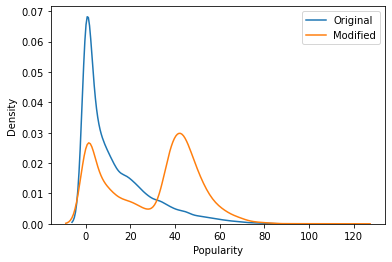

In [166]:
## distribution plot
sns.kdeplot(df['Popularity'], label = "Original")
sns.kdeplot(df_smogn['Popularity'], label = "Modified")
plt.legend();


### Dummy Regressor

In [167]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [168]:
dummy_train_r2 = dummy_reg.score(X_train, y_train)
dummy_test_r2 = dummy_reg.score(X_test, y_test)
dummy_preds = dummy_reg.predict(X_test)

dummy_RMSE = np.sqrt(mean_squared_error(y_test, dummy_preds))
dummy_MAE = mean_absolute_error(y_test, dummy_preds)

In [169]:
print(f'train r2: {dummy_train_r2}')
print(f'test r2: {dummy_test_r2}')
print(f'mae: {dummy_MAE}')
print(f'rmse: {dummy_RMSE}')
print(f'mse: {mean_squared_error(y_test, dummy_preds)}')

train r2: 0.0
test r2: -1.2715031723703958
mae: 20.476554382414204
rmse: 22.504888546273683
mse: 506.4700084802004


## Model Pipeline
After testing out many models, best performing ones are:
- Random Forest
- KNeighbors
- XGBoost
- Gradient Boosting Regressor (^^)

- GS for best parameters

In [222]:
est1 = GradientBoostingRegressor(loss="lad", max_features=None,
                                 min_samples_split=4, max_depth=7)

est2 = RandomForestRegressor(bootstrap=False, max_features="sqrt",
                             min_samples_split=3, n_estimators=100)

est4 = XGBRegressor(colsample_bytree=0.9, eval_metric="mae",
                        gamma=0.3, max_depth=3, min_child_weight=2,
                        objective="reg:squarederror", subsample=1.0)

stack_reg = StackingRegressor(estimators=[('est1', est2),
                                          ('est2', est4)
                                          ],
                              final_estimator=est1)

## Let's prepare a pipeline for testing
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', est2)
])

In [223]:
# (6.809, 103.028,
#  {'reg__bootstrap': False,
#   'reg__max_features': 'sqrt',
#   'reg__min_samples_split': 3,
#   'reg__n_estimators': 100})
# predictions are 
params_RF = {'reg__n_estimators': [100,200],
             'reg__max_features': ["log2", "sqrt", "auto"],
             'reg__min_samples_split': [2, 3, 4],
             'reg__bootstrap': [True, False]}


# (11.292, 188.902
#  {'reg__colsample_bytree': 0.9,
#   'reg__eval_metric': 'mae',
#   'reg__gamma': 0.3,
#   'reg__max_depth': 3,
#   'reg__min_child_weight': 2,
#   'reg__objective': 'reg:squarederror',
#   'reg__subsample': 1.0})
# some predictions are negative, but the spread is a bit wider
params_XGB = {'reg__objective': ["reg:squarederror", "reg:linear"],
              'reg__eval_metric': ["mae", "rmse"],
              'reg__min_child_weight': [2,4,5],
              'reg__gamma':[i/10.0 for i in range(3,6)],
              'reg__subsample':[i/10.0 for i in range(6,11)],
              'reg__colsample_bytree':[i/10.0 for i in range(6,11)],
              'reg__max_depth': [2,3,4]}

# (9.561, 174.814
#  {'reg__loss': 'lad',
#   'reg__max_depth': 7,
#   'reg__max_features': None,
#   'reg__min_samples_split': 4})
params_GBR = {'reg__loss': ["lad", "ls"],
              'reg__min_samples_split': [2, 4, 5],
              'reg__max_depth': [3, 5, 7],
              'reg__max_features': [None, 'auto', 'sqrt', 'log2']}

# stacked results:
# mae: 7.870297759363331
# rmse: 10.689729839259773
# mse: 174.5437302573545

In [224]:
%%time
## gridsearch it with correct parameter grid

gs = GridSearchCV(pipe, param_grid={}, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train, y_train)

gs_preds = gs.predict(X_test)

CPU times: user 6.72 s, sys: 136 ms, total: 6.85 s
Wall time: 13 s


In [225]:
gs.best_score_, gs.best_params_

(-10.822438077300063, {})

In [226]:

print("Stacked regressor results:\n")
gs_RMSE = np.sqrt(mean_squared_error(y_test, gs_preds))
gs_MAE = mean_absolute_error(y_test, gs_preds)

print(f'mae: {gs_MAE}')
print(f'rmse: {gs_RMSE}')
print(f'mse: {mean_squared_error(y_test, gs_preds)}')

Stacked regressor results:

mae: 6.8100717077584285
rmse: 10.174729924763511
mse: 103.52512904187807


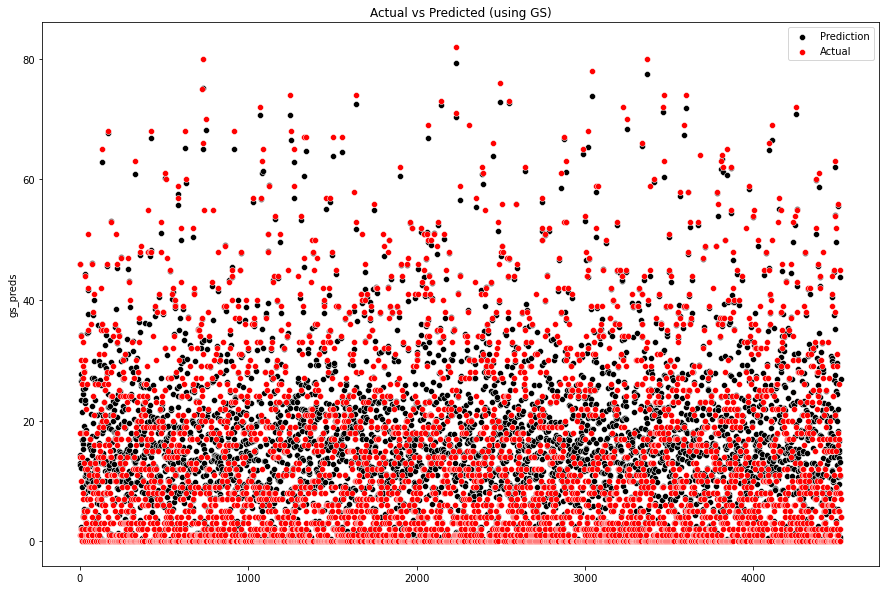

In [227]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, gs_preds)), columns=["y_test", "gs_preds"])
preds_df["absolute_error"] = preds_df["gs_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="gs_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)");
plt.xticks()
plt.yticks();


In [228]:
## write the predictions dataframe for Brian
# preds_df.to_csv("data/final_predictions.csv", index=False)

In [23]:
gs.

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        StackingRegressor(estimators=[('est1',
                                                                       RandomForestRegressor(bootstrap=False,
                                                                                             max_features='sqrt',
                                                                                             min_samples_split=3)),
                                                                      ('est2',
                                                                       XGBRegressor(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                               